In [3]:
import folium 
import numpy as np 
import matplotlib.pyplot as plt
import random as rd 
import requests
import json 
from folium import plugins
from folium.plugins import HeatMap
import time 
from networkx import DiGraph
from vrpy import VehicleRoutingProblem
import random as rd 
from time import * 
import osmnx as ox #
import networkx as nx
import plotly.graph_objects as go #
import numpy as np
from overpass import API
from sys import exc_info
from folium.features import DivIcon
import staticmaps
import io
from PIL import Image
import selenium
from selenium import webdriver
import os 
import staticmap
from staticmap import StaticMap, CircleMarker


In [5]:
rgb_orange = (245, 215, 170)
rgb_jaune = (248, 250, 197)
rgb_blanc = (255, 255, 255)
rgb_gris = (237, 238, 236)

green = '#80FF00'
yellow = '#FFFF00'
orange ='#FF8000'
red = '#FF0000'

In [6]:
def dist(u,v):
    return ((v[0]-u[0])**2 + (u[1]-v[1])**2)**0.5


def distanceGPS(A,B):
    """Retourne la distance en mètres entre les 2 points A et B connus grâce à
       leurs coordonnées GPS (en radians).
    """
    # Rayon de la terre en mètres (sphère IAG-GRS80)
    latA = 2*np.pi*A[0]/360
    longA = 2*np.pi*A[1]/360
    latB = 2*np.pi*B[0]/360
    longB = 2*np.pi*B[1]/360
    RT = 6378137
    # angle en radians entre les 2 points
    S = 2*np.sqrt(np.sin((latB-latA)/2)**2+np.cos(latA)*np.cos(latB)*np.sin((longB-longA)/2)**2)
    # S = np.arccos(np.sin(latA)*np.sin(latB) + np.cos(latA)*np.cos(latB)*np.cos(abs(longB-longA)))
    # distance entre les 2 points, comptée sur un arc de grand cercle
    return S*RT

    
def change(way, dmax, dmin, h): #
    """
    dmax c'est la distance maximale autorisée entre deux points : si est dépassé, on en crée de nouveaux
    dmin c'est l'inverse : on détruit un point. h c'est la distance optimale, entre les deux.   
    """
    N = len(way)
    c = 0 #C'est l'indice courant, on se déplace le long du chemin.
    while c+1 != N: 
        D = dist(way[c],way[c+1]) #Distance between start and arrival  
        x1, y1 = way[c]
        x2, y2 = way[c+1]
        if D > dmax: 
            x = (h/D)*(x2 - x1) + x1
            y = (h/D)*(y2 - y1) + y1
            way.insert(c+1, [x,y])
            c += 1
        elif D < dmin : 
            way.pop(c+1)
        else : 
            c += 1
        N = len(way)
    return way 


def route_dect(itineraire): 
    """
    Cette fonction nous permet de connaître toutes les routes de notre itinéraire. 
    Chacun de ces éléments correspond à une liste qui définit une route : noeud de début, noeud d'arrivée (en coordonnées)
    """
    theta = 0 
    N = len(itineraire)
    routes = [[itineraire[0]]] # Chaque élément de routes est une route, avec un point de départ, et un point d'arrivée. 
    for k in range(N-2):
        a = distanceGPS(itineraire[k+2], itineraire[k+1])
        b = distanceGPS(itineraire[k+2], itineraire[k])
        c = distanceGPS(itineraire[k], itineraire[k+1]) 
        try :
            theta = round(np.arccos((a**2 - b**2 - c**2)/(-2*b*c))*360/(2*np.pi))

        except ValueError:
            theta = 0
        if theta >= 35 : #cela signifie que le prochain point est le départ d'une nouvelle route. 
            routes.append([])
            routes[-1].append(itineraire[k+1]) #On ouvre une nouvelle route 
            routes[-2].append(itineraire[k]) #Et on ferme l'ancienne 
    return routes 

        

In [7]:
def find_nodes(coordinates, N, d): 
    """
    C'est la fonction que l'on va utiliser pour trouver toutes les noeuds dans un espace donné. 
    N c'est le nombre d'itinéraires que l'on va faire pour trouver tous ces noeuds. 

    """ 
    x_min = coordinates[0][0]
    x_max = coordinates[1][0]
    y_min = coordinates[0][1]
    y_max = coordinates[1][1]
    Delta_x = x_max-x_min
    Delta_y = y_max-y_min

    nodes = {}

    T = [] # C'est la liste des temps qui pour le moment est vide : dès que l'on trouve un nouveau point, on ajoute un temps
    Y = [] # C'est la liste du nombre de points trouvés : dès que l'on en trouve un, on ajoute un élément. 

    T_init = time()
    courant = 0 #C'est l'indice courant du noeud que l'on ajoute. On le change en 0, sinon cela décale tout pour plus tard. 
    for k in range(N): 
        print((k/N)*100)
        start_x = x_min + Delta_x*rd.random()
        start_y = y_min + Delta_x*rd.random()
        end_x = x_min + Delta_x*rd.random()
        end_y = y_min + Delta_x*rd.random()
        texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_y) + "," + str(start_x) + "&end=" + str(end_y) + "," + str(end_x) + "&timeUnit=second")
        texte = json.loads(texte.text)
        itineraire = texte['geometry']['coordinates']
        for el in itineraire:
            i=el[0]
            el[0]=el[1]
            el[1]=i
        itineraire = change(itineraire, 0.000125/3, 0.00005*(2/3), 0.0001125/3)
        routes = route_dect(itineraire)
        noeuds_courant = []
        noeuds_potentiel = []
        if len(routes) !=1 and len(routes)!=2 : #S'il n'y a qu'une seule route il n'y a pas de noeuds qui nous intéressent
            for route in routes[1:len(routes)-1] : 
                #if distanceGPS(route[0], route[1]) >= 70: 
                noeuds_courant.append(route[0])
            for noeud in noeuds_courant : 
                if len(nodes) !=0 :
                    d_min = 1000
                    for node in nodes : 
                        if distanceGPS(nodes[node], noeud) <= d_min: 
                            d_min = distanceGPS(nodes[node], noeud)
                    if d_min >= d: 
                        noeuds_potentiel.append(noeud)
                        Temps = time()
                        T.append(Temps-T_init)
                        Y.append(len(T))
                else : 
                    noeuds_potentiel.append(noeud)
                    Temps = time()
                    T.append(Temps-T_init)
                    Y.append(len(T))
            for noeud in noeuds_potentiel: 
                nodes[str(courant)] = noeud
                courant += 1
        #print(nodes)
    return nodes, routes, itineraire, T, Y

In [8]:
def find_notes_efficace(coordinates, N, d): 
    """
    C'est la fonction que l'on va utiliser pour trouver toutes les noeuds dans un espace donné. 
    Ici N, c'est le nombre de point que l'on va mettre en abscisse et en ordonnées : on aura donc au total environ 3*N^2 itinéraires parcourus
    
    """ 
    x_min = coordinates[0][0]
    x_max = coordinates[1][0]
    y_min = coordinates[0][1]
    y_max = coordinates[1][1]
    Delta_x = (x_max-x_min)/N
    Delta_y = (y_max-y_min)/N

    nodes = {}

    T = [] # C'est la liste des temps qui pour le moment est vide : dès que l'on trouve un nouveau point, on ajoute un temps
    Y = [] # C'est la liste du nombre de points trouvés : dès que l'on en trouve un, on ajoute un élément. 

    T_init = time()
    courant = 0 #C'est l'indice courant du noeud que l'on ajoute. On le change en 0, sinon cela décale tout pour plus tard. 


    matrice_noeuds = []
    for i in range(N): 
        matrice_noeuds.append([])
        for j in range(N): 
            element = [x_min + j*Delta_x, y_max - i*Delta_y]
            matrice_noeuds[i].append(element)
    itinary = []
    N_bas = round(0.5*N) # On prendra garde à toujours prendre des valeurs impaires pour N. 
    for i in range(N): 
        if i == 0 : 
            for j in range(N): 
                itinary.append([matrice_noeuds[0][j], matrice_noeuds[N_bas][j]])
        elif i == N_bas: 
            for j in range(N): 
                itinary.append([matrice_noeuds[N_bas][j], matrice_noeuds[2*N_bas][j]]) # 2*N_bas = N-1
                if j >= 1 and j < 2*N_bas: 
                    itinary.append([matrice_noeuds[N_bas][j], matrice_noeuds[0][0]]) 
                    itinary.append([matrice_noeuds[N_bas][j], matrice_noeuds[0][2*N_bas]]) 
                    itinary.append([matrice_noeuds[N_bas][j], matrice_noeuds[N_bas][0]]) 
                    itinary.append([matrice_noeuds[N_bas][j], matrice_noeuds[2*N_bas][2*N_bas]]) 
        for j in range(N):
            if j == 0 : 
                itinary.append([matrice_noeuds[i][0], matrice_noeuds[i][N_bas]]) 
            elif j == N_bas : 
                itinary.append([matrice_noeuds[i][N_bas], matrice_noeuds[i][2*N_bas]])

            
    
    k = 0 
    n = len(itinary)
    for iti in itinary: 
        print((k/n)*100)
        start_x = iti[0][0]
        start_y = iti[0][1]
        end_x = iti[1][0]
        end_y = iti[1][1]
        texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_y) + "," + str(start_x) + "&end=" + str(end_y) + "," + str(end_x) + "&timeUnit=second")
        texte = json.loads(texte.text)
        itineraire = texte['geometry']['coordinates']
        for el in itineraire:
            i=el[0]
            el[0]=el[1]
            el[1]=i
        itineraire = change(itineraire, 0.000125/3, 0.00005*(2/3), 0.0001125/3)
        routes = route_dect(itineraire)
        noeuds_courant = []
        noeuds_potentiel = []
        if len(routes) !=1 and len(routes)!=2 : #S'il n'y a qu'une seule route il n'y a pas de noeuds qui nous intéressent
            for route in routes[1:len(routes)-1] : 
                #if distanceGPS(route[0], route[1]) >= 70: 
                noeuds_courant.append(route[0])
            for noeud in noeuds_courant : 
                if len(nodes) !=0 :
                    d_min = 1000
                    for node in nodes : 
                        if distanceGPS(nodes[node], noeud) <= d_min: 
                            d_min = distanceGPS(nodes[node], noeud)
                    if d_min >= d: 
                        noeuds_potentiel.append(noeud)
                        Temps = time()
                        T.append(Temps-T_init)
                        Y.append(len(T))
                else : 
                    noeuds_potentiel.append(noeud)
                    Temps = time()
                    T.append(Temps-T_init)
                    Y.append(len(T))
            for noeud in noeuds_potentiel: 
                nodes[str(courant)] = noeud
                courant += 1
        #print(nodes)
        k += 1 
    return nodes, routes, itineraire, T, Y

In [43]:
nodes_test, roads_test, iti_test, T_test, Y_test = find_notes_efficace([[48.8407997654244, 2.33735138823297], [48.84948129630646, 2.3530925967680103]], 13, d = 50)

0.0
1.0416666666666665
2.083333333333333
3.125
4.166666666666666
5.208333333333334
6.25
7.291666666666667
8.333333333333332
9.375
10.416666666666668
11.458333333333332
12.5
13.541666666666666
14.583333333333334
15.625
16.666666666666664
17.708333333333336
18.75
19.791666666666664
20.833333333333336
21.875
22.916666666666664
23.958333333333336
25.0
26.041666666666668
27.083333333333332
28.125
29.166666666666668
30.208333333333332
31.25
32.29166666666667
33.33333333333333
34.375
35.41666666666667
36.45833333333333
37.5
38.54166666666667
39.58333333333333
40.625
41.66666666666667
42.70833333333333
43.75
44.79166666666667
45.83333333333333
46.875
47.91666666666667
48.95833333333333
50.0
51.041666666666664
52.083333333333336
53.125
54.166666666666664
55.208333333333336
56.25
57.291666666666664
58.333333333333336
59.375
60.416666666666664
61.458333333333336
62.5
63.541666666666664
64.58333333333334
65.625
66.66666666666666
67.70833333333334
68.75
69.79166666666666
70.83333333333334
71.875
72

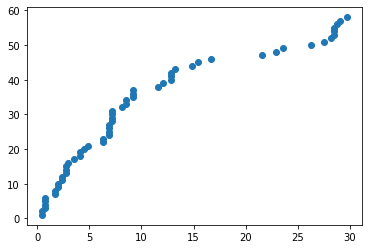

In [44]:
plt.scatter(T_test,Y_test)

In [45]:
draw(nodes_test, [[48.84948129630646, 2.3530925967680103],[48.84948129630646, 2.3530925967680103]])

In [9]:
def draw(noeuds, coordinates): 
    map = folium.Map(location=coordinates[0],zoom_start= 15)
    if type(noeuds) == dict: 
        for noeud in noeuds : 
            folium.Circle(location=noeuds[noeud], radius = 6, color = 'red').add_to(map)
    elif type(noeuds) == list: 
        for noeud in noeuds:
            folium.Circle(location=noeud, radius = 6, color = 'blue').add_to(map) 
    return map 


#UN EXEMPLE POUR TESTER QUE LES NOEUDS SONT BIEN DESSINÉS
nodes = {
    "0" : [48.84398020138173, 2.3389824418286684],
    "1" : [48.84391289824998, 2.3403395331628376],
    "2" : [48.84341388446145, 2.3415467019533205], 
    "3" : [48.84440778257574, 2.3420470955437263], 
    "4" : [48.84493806731674, 2.342361100721097], 
    "5" : [48.84626690825651, 2.3402599073836177], 
    "6" : [48.84603453758731, 2.341192794862878], 
    "7" : [48.84561265831214, 2.3427475462260468], 
    "8" : [48.846644247652264, 2.3416611494837696],
    "9" : [48.84643800878857, 2.3425796369204495], 
    "10" : [48.846103991165215, 2.343000254945767], 
    "11" : [48.84728104166769, 2.34060171018991], 
    "12" : [48.847129234485, 2.341971223536511], 
    "13" : [48.84690753608959, 2.342829751948107], 
    "14" : [48.846818141299046, 2.3433405220004384]
        }

In [49]:
Noeuds, routes, itineraire, T, Y = find_nodes([[48.8371091933485, 2.3293036413479378], [48.85156061428663, 2.3639513602239215]], 1500, d = 50)
map_noeuds = draw(Noeuds, [[48.8371091933485, 2.3293036413479378], [48.85156061428663, 2.3639513602239215]])
map_iti = draw(itineraire, [[48.8371091933485, 2.3293036413479378], [48.85156061428663, 2.3639513602239215]])
folium.PolyLine(routes).add_to(map_iti)
print("On a trouvé " + str(len(Noeuds)) + " noeuds")
map_noeuds

0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.33333333333333337
0.4
0.46666666666666673
0.5333333333333333
0.6
0.6666666666666667
0.7333333333333333
0.8
0.8666666666666666
0.9333333333333335
1.0
1.0666666666666667
1.1333333333333333
1.2
1.2666666666666666
1.3333333333333335
1.4000000000000001
1.4666666666666666
1.5333333333333332
1.6
1.6666666666666667
1.7333333333333332
1.7999999999999998
1.866666666666667
1.9333333333333333
2.0
2.0666666666666664
2.1333333333333333
2.1999999999999997
2.2666666666666666
2.3333333333333335
2.4
2.466666666666667
2.533333333333333
2.6
2.666666666666667
2.7333333333333334
2.8000000000000003
2.8666666666666667
2.933333333333333
3.0
3.0666666666666664
3.1333333333333333
3.2
3.266666666666666
3.3333333333333335
3.4000000000000004
3.4666666666666663
3.5333333333333337
3.5999999999999996
3.6666666666666665
3.733333333333334
3.8
3.8666666666666667
3.933333333333333
4.0
4.066666666666666
4.133333333333333
4.2
4.266666666666667
4.333333333

In [20]:
def find_nodes_carre_alea(coordinates, N, d): 
    """
    C'est la fonction que l'on va utiliser pour trouver toutes les noeuds dans un espace donné. 
    N c'est le nombre d'itinéraires que l'on va faire pour trouver tous ces noeuds. 

    """ 
    x_min = coordinates[0][0]
    x_max = coordinates[1][0]
    y_min = coordinates[0][1]
    y_max = coordinates[1][1]
    Delta_x = (x_max-x_min)/N
    Delta_y = (y_max-y_min)/N

    nodes = {}

    T = [] # C'est la liste des temps qui pour le moment est vide : dès que l'on trouve un nouveau point, on ajoute un temps
    Y = [] # C'est la liste du nombre de points trouvés : dès que l'on en trouve un, on ajoute un élément. 

    T_init = time()
    courant = 0 #C'est l'indice courant du noeud que l'on ajoute. On le change en 0, sinon cela décale tout pour plus tard. 
    for i in range(N):
        print((i/(N-1))*100)
        for j in range(N): 
            print(j)
            for k in range(5): 
                start_x = x_min + j*Delta_x 
                start_y = y_max - i*Delta_y  
                end_x = x_min + Delta_x*rd.random()
                end_y = y_min + Delta_x*rd.random()
                texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_y) + "," + str(start_x) + "&end=" + str(end_y) + "," + str(end_x) + "&timeUnit=second")
                texte = json.loads(texte.text)
                itineraire = texte['geometry']['coordinates']
                for el in itineraire:
                    i=el[0]
                    el[0]=el[1]
                    el[1]=i
                itineraire = change(itineraire, 0.000125/3, 0.00005*(2/3), 0.0001125/3)
                routes = route_dect(itineraire)
                noeuds_courant = []
                noeuds_potentiel = []
                if len(routes) !=1 and len(routes)!=2 : #S'il n'y a qu'une seule route il n'y a pas de noeuds qui nous intéressent
                    for route in routes[1:len(routes)-1] : 
                        #if distanceGPS(route[0], route[1]) >= 70: 
                        noeuds_courant.append(route[0])
                    for noeud in noeuds_courant : 
                        if len(nodes) !=0 :
                            d_min = 1000
                            for node in nodes : 
                                if distanceGPS(nodes[node], noeud) <= d_min: 
                                    d_min = distanceGPS(nodes[node], noeud)
                            if d_min >= d: 
                                noeuds_potentiel.append(noeud)
                                Temps = time()
                                T.append(Temps-T_init)
                                Y.append(len(T))
                        else : 
                            noeuds_potentiel.append(noeud)
                            Temps = time()
                            T.append(Temps-T_init)
                            Y.append(len(T))
                    for noeud in noeuds_potentiel: 
                        nodes[str(courant)] = noeud
                        courant += 1
                #print(nodes)
    return nodes, routes, itineraire, T, Y
                

In [21]:
nodes_test, roads_test, iti_test, T_test, Y_test = find_nodes_carre_alea([[48.8407997654244, 2.33735138823297], [48.84948129630646, 2.3530925967680103]], 13, d = 50)

0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
8.333333333333332
0
1
2
3
4
5
6
7
8
9
10
11
12
16.666666666666664
0
1
2
3
4
5
6
7
8
9
10
11
12
25.0
0
1
2
3
4
5
6
7
8
9
10
11
12
33.33333333333333
0
1
2
3
4
5
6
7
8
9
10
11
12
41.66666666666667
0
1
2
3
4
5
6
7
8
9
10
11
12
50.0
0
1
2
3
4
5
6
7
8
9
10
11
12
58.333333333333336
0
1
2
3
4
5
6
7
8
9
10
11
12
66.66666666666666
0
1
2
3
4
5
6
7
8
9
10
11
12
75.0
0
1
2
3
4
5
6
7
8
9
10
11
12
83.33333333333334
0
1
2
3
4
5
6
7
8
9
10
11
12
91.66666666666666
0
1
2
3
4
5
6
7
8
9
10
11
12
100.0
0
1
2
3
4
5
6
7
8
9
10
11
12


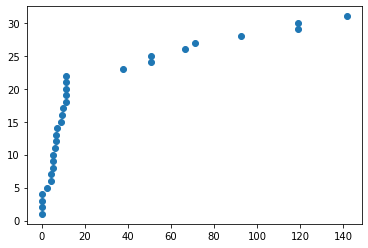

In [22]:
plt.scatter(T_test, Y_test)

In [24]:
draw(nodes_test, coordinates=[[48.8407997654244, 2.33735138823297], [48.84948129630646, 2.3530925967680103]])

In [13]:
Noeuds, routes, itineraire, T, Y= find_nodes([[48.843372312030844, 2.3386241424943277], [48.849719925907124, 2.3481134557632517]], 1500, d = 20)
map_noeuds = draw(Noeuds, [[48.843372312030844, 2.3386241424943277], [48.849719925907124, 2.3481134557632517]])
print("On a trouvé " + str(len(Noeuds)) + " noeuds")
for noeud in Noeuds : 
    folium.map.Marker(Noeuds[noeud], icon=DivIcon(icon_size=(250,36), icon_anchor=(0,0), html='<div style="font-size: 10pt">' + noeud + '</div>')).add_to(map_noeuds)
map_noeuds

0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.33333333333333337
0.4
0.46666666666666673
0.5333333333333333
0.6
0.6666666666666667
0.7333333333333333
0.8
0.8666666666666666
0.9333333333333335
1.0
1.0666666666666667
1.1333333333333333
1.2
1.2666666666666666
1.3333333333333335
1.4000000000000001
1.4666666666666666
1.5333333333333332
1.6
1.6666666666666667
1.7333333333333332
1.7999999999999998
1.866666666666667
1.9333333333333333
2.0
2.0666666666666664
2.1333333333333333
2.1999999999999997
2.2666666666666666
2.3333333333333335
2.4
2.466666666666667
2.533333333333333
2.6
2.666666666666667
2.7333333333333334
2.8000000000000003
2.8666666666666667
2.933333333333333
3.0
3.0666666666666664
3.1333333333333333
3.2
3.266666666666666
3.3333333333333335
3.4000000000000004
3.4666666666666663
3.5333333333333337
3.5999999999999996
3.6666666666666665
3.733333333333334
3.8
3.8666666666666667
3.933333333333333
4.0
4.066666666666666
4.133333333333333
4.2
4.266666666666667
4.333333333

KeyboardInterrupt: 

On peut faire de la parallélisation pour faire tourner plein de trucs en même temps. 

Faire les tests pour avoir le temps de VRPY. Voir sur les heuristiques qui sont plus ou moins raffinés. Voir aussi avec le nombre moyens de points par camion = voir si on peut réfléchir la capacité du camion.

Pour l'aspect temporel, on verra si on a le temps un peu plus tard. 



### On va désormais faire la fonction qui à partir d'une adresse renvoie le noeud qui lui correspond

In [14]:
def quel_noeud(adresse, ville, nodes): 
    """
    Une adresse est de la forme : 270 rue saint Jacques 
    Une ville est de la forme : Paris 
    Ces deux entrées sont sous la forme de chaine de carcatères. 
    """
    requete = ""
    for lettre in adresse: 
        if lettre == " ": 
            requete += "+"
        else : 
            requete += lettre 
    requete += "+"
    for lettre in ville: 
        if lettre == " ": 
            requete += "+"
        else : 
            requete += lettre 
    requete = "https://api-adresse.data.gouv.fr/search/?q=" + requete
    print(requete)
    texte = requests.get(requete)
    texte = json.loads(texte.text)
    coordonnées = texte['features'][0]['geometry']['coordinates']
    coordonneées = [coordonnées[1], coordonnées[0]]        

    d_min = 1000000
    for node in nodes : 
        if distanceGPS(nodes[node], coordonneées) <= d_min :
            mon_noeud = node 
            d_min = distanceGPS(nodes[node], coordonneées)
    return mon_noeud 



$\\[10cm]$

# Partie VRPY 

Le but dans cette partie c'est de donner une liste d'adresses et que à partir de VRPY, on est en retour la liste de l'odre dans lequel il faudra alors effectuer les trajets. Il trouve donc la tournée à effectuer par tous les camions. 

On prendra pour tester cette fonction des tournées avec 5 camions qui doivent livrer à 50 adresses différentes, avec toutes des demandes qui diffèrent. 

In [16]:
"""
On fait dans un premier temps la fonction qui à partir d'une liste de noeuds renvoie tous itinéraires entre les noeuds en parlant "noeuds". 
Cette fonction produit une liste immense. (de la taille du nombre de noeuds * nombre de noeuds). 
Pour un quartier de la taille de la moitié du 5ème, on a environ 300 noeuds. Cela donne une liste de 90000 éléments. 
Chacun de ces 9000 éléments est en fait une liste d'environ 4/5 éléments (noeuds pour aller de i vers j). 
"""

def construction_matrices(nodes):
    """
    Cette fonction prend en entrée la liste des noeuds qui ont été prédéfinis. 
    Elle renvoie : 
        - la matrice des itinéraires entre les noeuds : liste_itineraires[i][j] c'est la liste de tous les noeuds qu'il faut emprunter pour aller de i vers j. 
        - la matrice des temps de trajet entre les noeuds. 
        - la matrice des routes : liste_routes[i][j] : 
            o Si i et j ne sont pas reliés : vaut 0 
            o Si i et j sont bien reliés : c'est l'objet de la class route
    """
    N_nodes = len(nodes)
    matrix_durations = np.zeros((N_nodes,N_nodes))
    liste_routes = []
    liste_itineraires = []
    liste_iti_points = []

    i = 0 
    for node_start in nodes : 
        liste_itineraires.append([])
        liste_iti_points.append([])
        start_x = nodes[node_start][1] 
        start_y = nodes[node_start][0]
        print('i = ', i)
        j = 0
        for node_end in nodes :
            end_x = nodes[node_end][1] 
            end_y = nodes[node_end][0]
            texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_x) + "," + str(start_y) + "&end=" + str(end_x) + "," + str(end_y) + "&timeUnit=second")
            texte = json.loads(texte.text)
            itineraire = texte['geometry']['coordinates']
            duration = texte['duration']
            matrix_durations[i,j] = duration 
            for element in itineraire: 
                if round(element[0]) == 2 : 
                    p = element[0]
                    element[0] = element[1]
                    element[1] = p 
            itineraire_points = change(itineraire,  0.00025*(1/3), 0.0002*(1/3), 0.000225*(1/3))
            liste_iti_points.append([itineraire_points])

            #il va maintenant falloir modifier cela en une liste de noeud. 
            itineraire_noeuds = []
            node_courant = "-1"
            ending_point = itineraire_points[-1]
            min = 100000
            for point in itineraire_points:
                for node in nodes  : 
                    if node != node_courant and dist(point, nodes[node]) <= 0.00020 : 
                        itineraire_noeuds.append(node)
                        node_courant = node

            ending_node = itineraire_noeuds[-1] #On crée cette lista pour éviter des situations du type : [6, 4, 0, 4, 0] pour aller de 6 en 0... 
            lista = []
            for node in itineraire_noeuds: 
                if node != ending_node: 
                    lista.append(node)
            lista.append(ending_node)

            liste_itineraires[i].append(lista)  #Donc liste_itineraires[i][j] c'est l'itineraire pour aller de i vers j en parlant en noeud. 
            j+=1
        i+=1 
    return liste_itineraires, matrix_durations, liste_iti_points

In [17]:
"""
On définit ces données en variables globales pour justement éviter d'avoir à les recalculer à chaque demande vrpy. 
"""

liste_iti_noeuds, matrix_durations, liste_iti_points = construction_matrices(Noeuds)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
i =  20
i =  21
i =  22
i =  23
i =  24
i =  25
i =  26
i =  27
i =  28
i =  29
i =  30
i =  31
i =  32
i =  33
i =  34
i =  35
i =  36
i =  37
i =  38
i =  39
i =  40
i =  41
i =  42
i =  43
i =  44
i =  45
i =  46
i =  47
i =  48
i =  49
i =  50
i =  51
i =  52
i =  53
i =  54
i =  55
i =  56
i =  57
i =  58
i =  59
i =  60
i =  61
i =  62
i =  63
i =  64
i =  65
i =  66
i =  67
i =  68
i =  69
i =  70
i =  71
i =  72
i =  73
i =  74
i =  75
i =  76
i =  77
i =  78
i =  79
i =  80
i =  81
i =  82
i =  83
i =  84
i =  85
i =  86
i =  87
i =  88
i =  89
i =  90
i =  91
i =  92
i =  93
i =  94
i =  95
i =  96
i =  97
i =  98
i =  99
i =  100
i =  101
i =  102
i =  103
i =  104
i =  105
i =  106
i =  107
i =  108
i =  109
i =  110
i =  111
i =  112
i =  113
i =  114
i =  115
i =  116
i =  117
i =  118
i =  119
i =  120
i =  121
i =  122
i =

In [18]:
def vrpy_trouver_tournée(adresses_et_demandes, nodes, capacités):
    
    """
    Nodes c'est notre liste de noeuds que l'on aura donc bien prédéfinie. La première étape va consister à atribuer à toutes les adresses le noeud leur correspondant. 
    adresses_et_demandes c'est un dictionnaire : chacune des clés est pour une adresse. pour chaque adresse on a donc une liste d'un élément : un dictionnaire 
    où l'on va retrouver toutes les infos necssaires pour l'adresse en question. 

    Capacité, c'est le nombre de camion que l'on a à notre disposition pour effectuer les tournées dans le quartier. 

    """

    noeuds_et_demandes = {}
    for adresse in adresses_et_demandes: 
        noeud = quel_noeud(adresse, "Paris", nodes)
        if noeud not in noeuds_et_demandes: 
            noeuds_et_demandes[noeud] = [{'demande' : adresses_et_demandes[adresse][0]['demande']}]
        else : 
            noeuds_et_demandes[noeud][0]['demande'] += adresses_et_demandes[adresse][0]['demande']
    print(noeuds_et_demandes)
    
    """
    On a désormais converti notre dictionnaire des demandes des adresses en un dictionnaire de demandes reportée sur les noeuds. 
    Il faut désormais établir les tournées. On va vouloir renvoyer à la suite (même si plusieurs tournées sont effectuées en parallèle) la grande liste 
    qui contient tous les noeuds que l'on va visiter dans l'odre (c'est la concaténation de toutes les tournées)
    """

    G = DiGraph()
    for noeud in noeuds_et_demandes : # ici on crée les edges entre les noeuds et le début / la fin qui est au noeud 0. 
        G.add_edge('Source', noeud, cost = [matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1]])
        G.add_edge(noeud, 'Sink', cost = [matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0]])
        G.nodes[noeud]["demand"] = noeuds_et_demandes[noeud][0]['demande']
    for start in noeuds_et_demandes: 
        for ending in noeuds_et_demandes:
            G.add_edge(start, ending, cost = [matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1]])
    prob = VehicleRoutingProblem(G, mixed_fleet=True, load_capacity=capacités)
    return prob
    

In [60]:
adresses_et_demandes = {}

for k in range(200): 
    rues = {'1' : "val de grace", '2' : "soufflot", '3' : "cujas", '4' : "gay lussac", "5" :"rue des écoles", "6" : "rue valette", "7" : "rue de la cité", "8": "rue Danton"}
    rue = rues[str(rd.randint(1,8))]
    if rue == "val de grace": 
        numero = rd.randint(1,20)
    elif rue == "soufflot": 
        numero = rd.randint(1,23)
    elif rue == "cujas": 
        numero = rd.randint(1,25)
    elif rue == 'gay lussac': 
        numero = rd.randint(1,66)
    elif rue == 'rue valette':
        numero = rd.randint(1,20)
    elif rue == "rue des écoles": 
        numero = rd.randint(1,60)
    elif rue == "rue de la cité": 
        numero = rd.randint(1,10)
    elif rue == "rue danton": 
        numero = rd.randint(1,10)
    demande = rd.randint(1,2)
    adresses_et_demandes[str(numero) + " rue " + rue] = [{'demande' : demande}]

adresses_et_demandes


{'25 rue cujas': [{'demande': 1}],
 '9 rue val de grace': [{'demande': 1}],
 '57 rue rue des écoles': [{'demande': 1}],
 '57 rue rue Danton': [{'demande': 1}],
 '29 rue gay lussac': [{'demande': 2}],
 '7 rue rue des écoles': [{'demande': 2}],
 '4 rue cujas': [{'demande': 2}],
 '5 rue cujas': [{'demande': 2}],
 '40 rue rue des écoles': [{'demande': 2}],
 '19 rue val de grace': [{'demande': 1}],
 '19 rue rue des écoles': [{'demande': 1}],
 '14 rue soufflot': [{'demande': 1}],
 '6 rue rue valette': [{'demande': 1}],
 '5 rue rue de la cité': [{'demande': 2}],
 '4 rue soufflot': [{'demande': 1}],
 '18 rue cujas': [{'demande': 1}],
 '43 rue rue des écoles': [{'demande': 1}],
 '20 rue soufflot': [{'demande': 2}],
 '6 rue rue de la cité': [{'demande': 1}],
 '3 rue soufflot': [{'demande': 1}],
 '21 rue cujas': [{'demande': 1}],
 '10 rue soufflot': [{'demande': 2}],
 '18 rue val de grace': [{'demande': 1}],
 '18 rue rue Danton': [{'demande': 1}],
 '10 rue rue Danton': [{'demande': 1}],
 '23 rue 

In [62]:
"""
On aura donc exécuté la cellule qui donne actuellement 42 noeuds. Puis la cellule qui calcule matrix durations etc... 
"""

prob = vrpy_trouver_tournée(adresses_et_demandes, Noeuds, [12,20])
prob.solve()
itineraire = prob.best_routes

https://api-adresse.data.gouv.fr/search/?q=25+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=9+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=57+rue+rue+des+écoles+Paris
https://api-adresse.data.gouv.fr/search/?q=57+rue+rue+Danton+Paris
https://api-adresse.data.gouv.fr/search/?q=29+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=7+rue+rue+des+écoles+Paris
https://api-adresse.data.gouv.fr/search/?q=4+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=5+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=40+rue+rue+des+écoles+Paris
https://api-adresse.data.gouv.fr/search/?q=19+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=19+rue+rue+des+écoles+Paris
https://api-adresse.data.gouv.fr/search/?q=14+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=6+rue+rue+valette+Paris
https://api-adresse.data.gouv.fr/search/?q=5+rue+rue+de+la+cité+Paris
https://api-adresse.data.gouv.fr/search/?q=4+rue+soufflot+Pa

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:iteration 0, 5757.6
INFO:vrpy.vrp:iteration 1, 4805.2


{'128': [{'demande': 14}], '120': [{'demande': 15}], '40': [{'demande': 6}], '98': [{'demande': 20}], '92': [{'demande': 20}], '55': [{'demande': 9}], '119': [{'demande': 10}], '16': [{'demande': 4}], '150': [{'demande': 9}], '0': [{'demande': 6}], '103': [{'demande': 16}], '102': [{'demande': 4}], '6': [{'demande': 6}], '83': [{'demande': 8}], '107': [{'demande': 8}], '2': [{'demande': 1}], '1': [{'demande': 1}], '62': [{'demande': 1}], '152': [{'demande': 6}], '3': [{'demande': 2}], '109': [{'demande': 6}], '130': [{'demande': 5}], '67': [{'demande': 1}], '11': [{'demande': 1}], '90': [{'demande': 1}], '82': [{'demande': 4}], '91': [{'demande': 3}], '48': [{'demande': 2}]}


INFO:vrpy.vrp:iteration 2, 4527.7
INFO:vrpy.vrp:iteration 3, 4527.7
INFO:vrpy.vrp:iteration 4, 4429.7
INFO:vrpy.vrp:iteration 5, 4387.0
INFO:vrpy.vrp:iteration 6, 4317.4
INFO:vrpy.vrp:iteration 7, 4209.7
INFO:vrpy.vrp:iteration 8, 4209.7
INFO:vrpy.vrp:iteration 9, 4195.3
INFO:vrpy.vrp:iteration 10, 4151.6
INFO:vrpy.vrp:iteration 11, 4100.1
INFO:vrpy.vrp:iteration 12, 4100.1
INFO:vrpy.vrp:iteration 13, 4083.6
INFO:vrpy.vrp:iteration 14, 4036.8
INFO:vrpy.vrp:iteration 15, 4026.3
INFO:vrpy.vrp:iteration 16, 4009.4
INFO:vrpy.vrp:iteration 17, 4004.0
INFO:vrpy.vrp:iteration 18, 3948.3
INFO:vrpy.vrp:iteration 19, 3912.3
INFO:vrpy.vrp:iteration 20, 3912.3
INFO:vrpy.vrp:iteration 21, 3912.3
INFO:vrpy.vrp:iteration 22, 3912.3
INFO:vrpy.vrp:iteration 23, 3912.3
INFO:vrpy.vrp:iteration 24, 3912.3
INFO:vrpy.vrp:iteration 25, 3883.6
INFO:vrpy.vrp:iteration 26, 3864.7
INFO:vrpy.vrp:iteration 27, 3862.0
INFO:vrpy.vrp:iteration 28, 3835.4
INFO:vrpy.vrp:iteration 29, 3827.7
INFO:vrpy.vrp:iteration 30, 

In [63]:
prob.best_routes

{1: ['Source', '98', 'Sink'],
 2: ['Source', '92', 'Sink'],
 3: ['Source', '1', 'Sink'],
 4: ['Source', '2', '16', '102', '11', '48', 'Sink'],
 5: ['Source', '91', '150', '107', 'Sink'],
 6: ['Source', '83', '109', '6', 'Sink'],
 7: ['Source', '103', '82', 'Sink'],
 8: ['Source', '128', '0', 'Sink'],
 9: ['Source', '55', '130', '152', 'Sink'],
 10: ['Source', '62', '120', 'Sink'],
 11: ['Source', '3', '67', '119', '90', '40', 'Sink']}

$\\[10cm]$

# Partie class routes et class quartier 

On définit dans cette partie la class route, la class quartier et les différentes méthodes draw : on s'approche du résultat final

In [181]:
import time

class Route : 
    def __init__(self, depart, arrivee):
        self.depart = depart
        self.arrivee = arrivee
        self.traffic = 1
        self.color = (0,0,0) #On initialise la couleur d'une route en disant qu'elle est noire au départ 
        self.road_type = 'rue' #Au début, pas d'apriori, tout le monde est une rue 
        

    def draw(self, map, liste_routes): 
        point_0 = Noeuds[self.depart]
        point_1 = Noeuds[self.arrivee]
        latlngs = [point_0, point_1]
        if self.road_type == 'rue':
            max_rue = 0 
            for i in range(len(liste_routes)): 
                for j in range(len(liste_routes)): 
                    if liste_routes[i][j] !=0:
                        if liste_routes[i][j].road_type == 'rue' and liste_routes[i][j].traffic > max_rue : 
                            max_rue = liste_routes[i][j].traffic
            self.traffic = self.traffic/max_rue 
        elif self.road_type == 'avenue': 
            max_avenue = 0 
            for i in range(len(liste_routes)): 
                for j in range(len(liste_routes)): 
                    if liste_routes[i][j] !=0:
                        if liste_routes[i][j].road_type == 'avenue' and liste_routes[i][j].traffic > max_avenue :
                            max_avenue = liste_routes[i][j].traffic
            self.traffic = self.traffic/max_avenue 
        elif self.road_type == 'grand axe': 
            max_grand_axe = 0 
            for i in range(len(liste_routes)): 
                for j in range(len(liste_routes)): 
                    if liste_routes[i][j] !=0:
                        if liste_routes[i][j].road_type == 'grand axe' and liste_routes[i][j].traffic > max_grand_axe :
                            max_grand_axe = liste_routes[i][j].traffic
            self.traffic = self.traffic/max_grand_axe 
        if self.traffic <= 0.5 : 
            color = '#%02x%02x%02x' % (round(2*self.traffic*255), 255,0) 
            folium.PolyLine(latlngs, color = color, weight = 9).add_to(map)
        else : 
            color = '#%02x%02x%02x' % (255, 255 - round(self.traffic*255), 0)
            folium.PolyLine(latlngs, color = color, weight = 9).add_to(map)
        
    

    def other_draw(self, map): 
        point_0 = Noeuds[self.depart]
        point_1 = Noeuds[self.arrivee]
        latlngs = [point_0, point_1]
        if self.road_type == 'rue': 
            color = '#%02x%02x%02x' % (10,10,10) #cette color c'est celle que prendra la case au moment de l'affichage, mais ce n'est pas la couleur de la rue est restée la même.  
            folium.PolyLine(latlngs, color = color, weight = 6).add_to(map)
        elif self.road_type == 'avenue': 
            color = '#%02x%02x%02x' % (130,130,130)
            folium.PolyLine(latlngs, color = color, weight = 9).add_to(map)
        elif self.road_type == 'grand axe':
            color = '#%02x%02x%02x' % (200,200,200)
            folium.PolyLine(latlngs, color = color, weight = 12).add_to(map)
        else :
            color = '#FF0000'
            folium.PolyLine(latlngs, color = color, weight = 10).add_to(map)

        
# ------------------------------------------------------------------------------------------------------------

class image_du_quartier:
    def __init__(self):
        self.zoom = 15
        self.ecart_axes = 0.006
        self.localisation = Noeuds['0']
        self.pix_x_dist, self.pix_y_dist, self.image  = test_echelle(self.zoom, self.localisation, self.ecart_axes)


# ------------------------------------------------------------------------------------------------------------

class quartier : 
    """
    C'est la classe qui définit notre grand quartier.
    Un de ses attributs est justement toutes les routes qui le constitue : on aura crée cette liste au préalable après avoir trouvé les noeuds
    """
    def __init__(self, itineraire):  
        liste_routes = create_liste_route(itineraire)
        self.liste_routes = liste_routes 
        self.image_du_quartier = image_du_quartier()

    def draw(self): 
        map = folium.Map(location=nodes['0'],zoom_start= 15) #nodes['0'] c'est les mines de paris 
        for i in range(len(self.liste_routes)): 
            for j in range(len(self.liste_routes)):
                element = self.liste_routes[i][j]
                if element != 0 :
                    route = element #On dit que juste que cet élément est donc en fait bien une route 
                    element.other_draw(map)
        return map 

    def draw_traffic(self): 
        map = folium.Map(location=nodes['0'],zoom_start= 15) #nodes['0'] c'est les mines de paris 
        for i in range(len(self.liste_routes)): 
            for j in range(len(self.liste_routes)):
                element = self.liste_routes[i][j]
                if element != 0 :
                    element.draw(map, self.liste_routes)
        return map 
    
    def change_couleur_routes(self):
        im_quart = self.image_du_quartier
        image = im_quart.image
        location = im_quart.localisation
        pix_x_dist = im_quart.pix_x_dist
        pix_y_dist = im_quart.pix_y_dist
        for i in range(len(self.liste_routes)):
            for j in range(len(self.liste_routes)):
                if self.liste_routes[i][j] != 0:
                    self.liste_routes[i][j].color = (0,0,0)
                    N_it = 0
                    while dist_color(self.liste_routes[i][j].color,rgb_blanc) >= 8 and dist_color(self.liste_routes[i][j].color,rgb_jaune) >= 8 and dist_color(self.liste_routes[i][j].color,rgb_orange) >= 8 and dist_color(self.liste_routes[i][j].color,rgb_gris) >= 8 and N_it < 200 :
                        route = self.liste_routes[i][j]
                        x = Noeuds[route.depart]
                        y = Noeuds[route.arrivee]
                        k = rd.random()
                        if k <= 0.90 and k > 0.1 : #Il faut que l'on se place au moins à 10% de la route, et pas à plus de 90% (sinon on est au niveau des noeuds où l'on n'a pas forcément le type de la route que l'on cherche mais celui de celle qui lui est perpendiculaire)
                            point = [k*x[0] + (1-k)*y[0], k*x[1] + (1-k)*y[1]] #C'est un point pris au hasard sur le segment formé par les deux noeuds
                            coor = equivalence_coorGPS_coorimage(image, location, pix_x_dist, pix_y_dist, point)
                            color = quel_couleur(image, coor)
                            self.liste_routes[i][j].color = color #La couleur de la route est bien la couleur EXACTE de la route (et pas un approximation)
                            N_it += 1
                    print(k, N_it)
                    if N_it == 200 : #Si la raison pour laquelle nous sommes sortis de la boucle est que nous avons dépassé le nombre d'itérations acceptable
                        print("Nous n'avons pas réussi à trouver le type de la route reliant le noeud ", i, " et le noeud ", j)
                        #self.liste_routes[i][j].color = rgb_orange #Si jamais nous n'avons pas trouvé le type de la rue : on dit que c'est un grand axe (pour éviter une mauvaise normalisation d'un axe plus important)
                        road_type = 'grand axe'

                    if dist_color(self.liste_routes[i][j].color,rgb_blanc)<=8 or dist_color(self.liste_routes[i][j].color,(0,0,0))<=8 or dist_color(self.liste_routes[i][j].color,rgb_gris)<=8: 
                        road_type = 'rue'
                    elif dist_color(self.liste_routes[i][j].color,rgb_jaune)<=8:
                        road_type = 'avenue'
                    elif dist_color(self.liste_routes[i][j].color,rgb_orange)<=8: 
                        road_type = 'grand axe'
                    self.liste_routes[i][j].road_type = road_type

# ------------------------------------------------------------------------------------------------------------
#La fonction ci-dessous servait autrefois, quand on crééait les classes routes au préalable
"""
def create_matrice_routes(itineraire, nodes):
    matrice_routes = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
    for iti in itineraire :
        liste_noeuds = itineraire[iti]
        for i in range (len(liste_noeuds) - 1) :
            if liste_noeuds[i] == "Source" :
                chemin = liste_iti_noeuds[0][eval(liste_noeuds[i+1])]
            elif liste_noeuds[i+1] == "Sink":
                chemin = liste_iti_noeuds[eval(liste_noeuds[i])][0]
            else : 
                chemin = liste_iti_noeuds[eval(liste_noeuds[i])][eval(liste_noeuds[i+1])]
            for j in range(len(chemin)-1): 
                if matrice_routes[eval(chemin[j])][eval(chemin[j+1])] == 0 :
                    matrice_routes[eval(chemin[j])][eval(chemin[j+1])] = Route(chemin[j], chemin[j+1])
                else : 
                    matrice_routes[eval(chemin[j])][eval(chemin[j+1])].traffic += 1
    return matrice_routes
"""

# ------------------------------------------------------------------------------------------------------------

def create_liste_route(itineraire): 
    i = 0 
    liste_routes = []
    for i in range(len(Noeuds)): 
        liste_routes.append([])
        for j in range(len(Noeuds)): 
            liste_routes[i].append(0)
    for iti in itineraire: 
        print("Nous sommes au trajet numéro ", iti)
        way = itineraire[(iti)]
        for l in range(len(way)-1): 
            if way[l] == 'Source':
                noeud = way[l+1]
                chemin = liste_iti_noeuds[0][eval(noeud)]
                for k in range(len(chemin)-1):
                    a = eval(chemin[k])
                    b = eval(chemin[k+1])
                    if liste_routes[a][b]==0 and liste_routes[b][a]==0: #Si jamais la route n'est pas encore construite: 
                        if a >= b :  #On veut une matrice trigonale supérieure 
                            liste_routes[b][a] = Route(chemin[k], chemin[k+1])
                        else : 
                            liste_routes[a][b] = Route(chemin[k], chemin[k+1])
                    else : 
                        if a >= b : 
                            liste_routes[b][a].traffic += 1
                        else : 
                            liste_routes[a][b].traffic += 1
            elif way[l+1] == 'Sink':
                chemin = liste_iti_noeuds[eval(way[l])][0]
                for k in range(len(chemin)-1):
                    a = eval(chemin[k])
                    b = eval(chemin[k+1])
                    if liste_routes[a][b]==0 and liste_routes[b][a]==0: #Si jamais la route n'est pas encore construite: 
                        if a >= b :  #On veut une matrice trigonale supérieure 
                            liste_routes[b][a] = Route(chemin[k], chemin[k+1])
                        else : 
                            liste_routes[a][b] = Route(chemin[k], chemin[k+1])
                    else : 
                        if a >= b : 
                            liste_routes[b][a].traffic += 1
                        else : 
                            liste_routes[a][b].traffic += 1
            else :
                chemin = liste_iti_noeuds[eval(way[l])][eval(way[l+1])]
                for k in range(len(chemin)-1):
                    a = eval(chemin[k])
                    b = eval(chemin[k+1])
                    if liste_routes[a][b]==0 and liste_routes[b][a]==0: #Si jamais la route n'est pas encore construite: 
                        if a >= b :  #On veut une matrice trigonale supérieure 
                            liste_routes[b][a] = Route(chemin[k], chemin[k+1])
                        else : 
                            liste_routes[a][b] = Route(chemin[k], chemin[k+1])
                    else : 
                        if a >= b : 
                            liste_routes[b][a].traffic += 1
                        else : 
                            liste_routes[a][b].traffic += 1
    return liste_routes

# ------------------------------------------------------------------------------------------------------------

def center(a,b): 
    return [(a[0]+b[0])/2, (a[1]+b[1])/2]

# ------------------------------------------------------------------------------------------------------------

def dist_color(color1, color2): 
    """
    Cette fonction sert à donner la distance entre deux couleurs.
    """
    return np.sqrt((color2[0]-color1[0])**2+(color2[1]-color1[1])**2+(color2[2]-color1[2])**2)

# ------------------------------------------------------------------------------------------------------------

def test_echelle(zoom, location, ecart_axes):
    """
    Cette fonction prend un zoom dans folium et renvoie l'échelle correspondante (attention, on doit adapter la ligne de référence pour qu'elle apparaisse bien dans 
    l'image et séparée du point original)

    Des tests ont été effectué : cette fonction fonctionne correctement. 
    """

    bas_gauche = [location[0]-0.01, location[1]-ecart_axes]
    haut_gauche_1 = [location[0]+0.01, location[1]-ecart_axes]
    haut_droite = [location[0]+ecart_axes, location[1]+0.01]
    haut_gauche_2 = [location[0]+ecart_axes, location[1]-0.01]

    m = folium.Map(location = location,zoom_start=zoom)
    folium.PolyLine([bas_gauche, haut_gauche_1], color = '#%02x%02x%02x' % (0, 0, 0)).add_to(m)
    folium.PolyLine([haut_gauche_2, haut_droite], color = '#%02x%02x%02x' % (0, 0, 0)).add_to(m)

    mapName = 'test_18h39.html'
    m.save(mapName)
    mapUrl = 'file://{0}/{1}'.format(os.getcwd(), mapName)
    options = webdriver.ChromeOptions()
    #options.add_argument("--start-maximized")
    #options.add_argument('--log-level=3')
    driver = webdriver.Chrome(executable_path="chromedriver",chrome_options=options)
    #driver.set_window_size(1920,1080)

    # wait for 5 seconds for the maps and other assets to be loaded in the browser
    driver.get(mapUrl)
    time.sleep(3)
    driver.save_screenshot('test_18h44.png')
    driver.close()
    print("La capture d'écran a bien été enregistré")

    im = plt.imread('test_18h44.png')
    N_pixel_x = im.shape[0]
    N_pixel_y = im.shape[1]
    pixel_x_courant = N_pixel_x//2
    pixel_y_courant = N_pixel_y//2
    couleur = (int(list(im[pixel_x_courant][pixel_y_courant]*255)[0]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[1]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[2]))
    while couleur != (0,0,0): 
        pixel_x_courant = pixel_x_courant
        pixel_y_courant -= 1
        couleur = (int(list(im[pixel_x_courant][pixel_y_courant]*255)[0]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[1]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[2]))
    delta_y_pixel = N_pixel_y//2 - pixel_y_courant
    distance = dist(location, [location[0], bas_gauche[1]])

    pixel_x_courant = N_pixel_x//2
    pixel_y_courant = N_pixel_y//2
    couleur = (int(list(im[pixel_x_courant][pixel_y_courant]*255)[0]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[1]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[2]))
    while couleur != (0,0,0): 
        pixel_y_courant = pixel_y_courant
        pixel_x_courant -= 1
        couleur = (int(list(im[pixel_x_courant][pixel_y_courant]*255)[0]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[1]), int(list(im[pixel_x_courant][pixel_y_courant]*255)[2]))
    delta_x_pixel = N_pixel_x//2 - pixel_x_courant
    distance = dist(location, [haut_gauche_2[0], location[1]])

    return(distance/delta_x_pixel, distance/delta_y_pixel, im)

# ------------------------------------------------------------------------------------------------------------

def equivalence_coorGPS_coorimage(image, location, pix_x_dist, pix_y_dist, point):
    """
    Prend les coordonnées d'un point (point = [x,y]) et renvoie ses coordonnée sur l'image sous la forme d'une liste [i,j].
    On a accès à location au centre de la carte pour avoir une référence. 

    Des tests ont été effectué : cette fonction fonctionne correctement. 
    """
    N_pixel_x = image.shape[0]
    N_pixel_y = image.shape[1]
    point_origine = [location[0]-(N_pixel_x//2)*pix_x_dist, location[1]-(N_pixel_y//2)*pix_y_dist] #C'est le point de coordonnées sur l'image [0,0]
    distance_en_x = dist(point_origine, [point[0], point_origine[1]])
    distance_en_y = dist(point_origine, [point_origine[0], point[1]])
    return [round(distance_en_x*(1/pix_x_dist)), round(distance_en_y*(1/pix_y_dist))]

def quel_couleur(image, coor): 
    coor = image.shape[0]-coor[0], coor[1]
    temp_color = image[coor[0]][coor[1]]
    return int(temp_color[0]*255), int(temp_color[1]*255), int(temp_color[2]*255)
    

In [74]:
mon_quartier = quartier(itineraire)

Nous sommes au trajet numéro  1
Nous sommes au trajet numéro  2
Nous sommes au trajet numéro  3
Nous sommes au trajet numéro  4
Nous sommes au trajet numéro  5
Nous sommes au trajet numéro  6
Nous sommes au trajet numéro  7
Nous sommes au trajet numéro  8
Nous sommes au trajet numéro  9
Nous sommes au trajet numéro  10
Nous sommes au trajet numéro  11


/var/folders/x5/lg8dlnz12rzbjzkktlnsy0f00000gn/T/ipykernel_8718/1821156564.py:223: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path="chromedriver",chrome_options=options)


La capture d'écran a bien été enregistré


In [66]:
mon_quartier.change_couleur_routes()

0.6014118148759904 1
0.19625742832091309 1
0.8514278625319074 1
0.6897423492662375 1
0.6269598319670211 1
0.8846699039273874 17
0.3442608200721451 1
0.5836935450302114 2
0.4557036905929741 2
0.8286848319576231 1
0.10255222956521559 5
0.2899555785389768 1
0.5404373684539744 100
0.7554288779400659 100
0.13538080655525342 16
0.5761085846970081 3
0.12989178008966484 100
0.8262455809279342 9
0.43773481696956706 1
0.21431479450684154 13
0.2485083746998057 4
0.7291281692446826 7
0.4803363085697059 3
0.3835066316365847 100
0.7957301601237301 100
0.8935127819878078 5
0.11523551388143527 100
0.3451716875950197 1
0.25381666002075476 11
0.11903292143115884 17
0.7009765444015177 19
0.8320332340609593 24
0.552165068056132 1
0.5110031337480179 35
0.1736038609082965 1
0.5054392114735051 1
0.17117740398523873 75
0.6224763979431663 37
0.6842030579531576 100
0.18993679522528384 100
0.27425137313955317 1
0.11651617014373372 1
0.8428461116853847 2
0.7689706965443379 100
0.425571602602578 1
0.68705542065684

### Visualisons les noeuds et leur numéro 

In [67]:
m = folium.Map(location=Noeuds['0'], zoom_start=15)
for i in range(len(mon_quartier.liste_routes)):
    for j in range(len(mon_quartier.liste_routes)):
        if mon_quartier.liste_routes[i][j] != 0: 
            depart = mon_quartier.liste_routes[i][j].depart
            arrivee = mon_quartier.liste_routes[i][j].arrivee
            dep, arr = Noeuds[depart], Noeuds[arrivee]
            color = mon_quartier.liste_routes[i][j].color
            folium.Marker(location=dep, color = 'green').add_to(m)
            folium.Marker(location=arr, color = 'red').add_to(m)
            folium.Circle(location = center(dep, arr), color = '#%02x%02x%02x' % color, radius = 10).add_to(m)
for noeud in Noeuds : 
    folium.map.Marker(Noeuds[noeud], icon=DivIcon(icon_size=(250,36), icon_anchor=(0,0), html='<div style="font-size: 10pt">' + noeud + '</div>')).add_to(m)
m

### Visualisons les types de route que nous avons trouvé 

C'est normal si beaucoup sont encore rouge, la méthode doit encore être optimisée

In [175]:
# NB : on a mis other_draw dans le draw de la grille, juste pour avoir visuellement le type d'une route
m = mon_quartier_2.draw()
m


In [69]:
#Pour connaitre les valeurs des grands traffic 

routes = mon_quartier.liste_routes
for i in range(len(routes)):
    for j in range(len(routes)):
        if routes[i][j] != 0:
            if routes[i][j].traffic>1:
                print(routes[i][j].traffic)

4
12
2
7
2
8
4
2
3
4
3
2
3
4
2
2
3
10
2
3
5
9
3
3
6
3
2
3
4
3
3
2
4
3
2
2
2
2
3
2
2
3
5
6
3
5
2
2
3
2
2
3
5
2
2
3
2
2
2
3
3
2
3


### Donnons un aperçu du trafic, où l'on n'a pas encore pris en compte la pondération par la taille de la route

In [71]:
m = mon_quartier.draw_traffic()

for noeud in Noeuds: 
    folium.map.Marker(
        Noeuds[noeud],
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10">'+ noeud+ '</div>'
            )
        ).add_to(m)
m

In [ ]:
for i in range(len(liste_iti_noeuds)): 
    for j in range(len(liste_iti_noeuds)):
        chemin = liste_iti_noeuds
        for k in range(len(chemin)-1):
            if chemin[k] == '17' and chemin[k+1] == '19':
                print('Le problème est quand on trace le chemin', i, 'vers', j)
            if chemin[k] == '19' and chemin[k+1] == '17':
                print('Le problème est quand on trace le chemin', i, 'vers', j)

### La case ci-dessous utile si l'on décide d'utiliser un autre tile que OpenStreetMap 

In [80]:

import io
from PIL import Image
import selenium
from selenium import webdriver
import time 
import os 

attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
tiles = 'https://{s}.basemaps.cartocdn.com/rastertiles/voyager_nolabels/{z}/{x}/{y}{r}.png'

m = folium.Map(location = [48.843347209069606, 2.34157366490164], width='100%', height='100%',zoom_start=20, tiles = tiles, attr= attr)

mapName = 'test_map_folium.html'
m.save(mapName)
mapUrl = 'file://{0}/{1}'.format(os.getcwd(), mapName)
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
options.add_argument('--log-level=3')
driver = webdriver.Chrome(executable_path="chromedriver",chrome_options=options)
driver.set_window_size(1920,1080)

# wait for 5 seconds for the maps and other assets to be loaded in the browser
driver.get(mapUrl)
time.sleep(10)
driver.save_screenshot('output.png')
print("La capture d'écran a bien été enregistré")


/var/folders/x5/lg8dlnz12rzbjzkktlnsy0f00000gn/T/ipykernel_8718/1185023088.py:19: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path="chromedriver",chrome_options=options)


La capture d'écran a bien été enregistré


In [78]:
Noeuds['1']

[48.847337404136255, 2.340847028851934]

## Test avec la dataframe

In [87]:
import pandas as pd  
    
df = pd.read_csv("/Users/nicolasplantier/Documents/Mines Paris/UE 22 - Ingénieurie logicielle/Input 2/output_df_test.csv")  

mask = df['cluster'] == 2 #C'est le 5ème arrondissement et même beaucoup plus large 
df = df[mask]
liste_coor_temp = []
for k in range(len(df)): 
    texte = df.iloc[k]['geometry']
    a = ''
    b = ''
    i = 0 
    while texte[i] != '2': 
        i +=1
    while texte[i] != ' ': 
        a += texte[i]
        i += 1
    i += 1
    while texte[i] != ')':
        b += texte[i]
        i += 1
    coor = [eval(a), eval(b)]
    liste_coor_temp.append(coor)

liste_coor = []
x_min, y_min = 2.337706787840913, 48.84164421936378
x_max, y_max = 2.3549890144293557, 48.85001306461591
for coor in liste_coor_temp: 
    if coor[0] < x_max and coor[0] > x_min and coor[1] > y_min and coor[1] < y_max:
        liste_coor.append(coor)

for k in range(len(liste_coor)): 
    liste_coor[k] = [liste_coor[k][1], liste_coor[k][0]]
    


In [88]:
def quel_noeud_coor(coor, ville, nodes): 
    d_min = 1000000
    for node in nodes : 
        if distanceGPS(nodes[node], coor) <= d_min :
            mon_noeud = node 
            d_min = distanceGPS(nodes[node], coor)
    return mon_noeud 


def vrpy_trouver_tournée_coor(liste_coor, nodes, capacités):
    
    """
    Nodes c'est notre liste de noeuds que l'on aura donc bien prédéfinie. La première étape va consister à atribuer à toutes les adresses le noeud leur correspondant. 
    adresses_et_demandes c'est un dictionnaire : chacune des clés est pour une adresse. pour chaque adresse on a donc une liste d'un élément : un dictionnaire 
    où l'on va retrouver toutes les infos necssaires pour l'adresse en question. 

    Capacité, c'est le nombre de camion que l'on a à notre disposition pour effectuer les tournées dans le quartier. 

    """

    noeuds_et_demandes = {}
    for coor in liste_coor: 
        noeud = quel_noeud_coor(coor, "Paris", nodes)
        if noeud not in noeuds_et_demandes: 
            noeuds_et_demandes[noeud] = [{'demande' : 0.05}]
        else : 
            noeuds_et_demandes[noeud][0]['demande'] += 0.05
    print(noeuds_et_demandes)
    
    """
    On a désormais converti notre dictionnaire des demandes des adresses en un dictionnaire de demandes reportée sur les noeuds. 
    Il faut désormais établir les tournées. On va vouloir renvoyer à la suite (même si plusieurs tournées sont effectuées en parallèle) la grande liste 
    qui contient tous les noeuds que l'on va visiter dans l'odre (c'est la concaténation de toutes les tournées)
    """

    G = DiGraph()
    for noeud in noeuds_et_demandes : # ici on crée les edges entre les noeuds et le début / la fin qui est au noeud 0. 
        G.add_edge('Source', noeud, cost = [matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1]])
        G.add_edge(noeud, 'Sink', cost = [matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0]])
        G.nodes[noeud]["demand"] = noeuds_et_demandes[noeud][0]['demande']
    for start in noeuds_et_demandes: 
        for ending in noeuds_et_demandes:
            G.add_edge(start, ending, cost = [matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1]])
    prob = VehicleRoutingProblem(G, mixed_fleet=True, load_capacity=capacités)
    return prob


prob = vrpy_trouver_tournée_coor(liste_coor, Noeuds, [12,20])
prob.solve()
itineraire = prob.best_routes
mon_quartier_2 = quartier(itineraire)
mon_quartier.change_couleur_routes()
m = mon_quartier.draw_traffic()
for noeud in Noeuds: 
    folium.map.Marker(
        Noeuds[noeud],
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10">'+ noeud+ '</div>'
            )
        ).add_to(m)
m

{'7': [{'demande': 3.8499999999999943}], '9': [{'demande': 14.700000000000074}], '109': [{'demande': 2.9999999999999973}], '46': [{'demande': 5.849999999999987}], '130': [{'demande': 6.549999999999985}], '131': [{'demande': 2.5999999999999988}], '115': [{'demande': 2.3}], '140': [{'demande': 17.550000000000114}], '48': [{'demande': 2.1000000000000005}], '5': [{'demande': 0.8500000000000002}], '70': [{'demande': 8.14999999999998}], '119': [{'demande': 1.0500000000000003}], '90': [{'demande': 4.249999999999993}], '103': [{'demande': 2.3499999999999996}], '92': [{'demande': 10.95000000000002}], '10': [{'demande': 11.200000000000024}], '132': [{'demande': 3.7499999999999947}], '62': [{'demande': 4.099999999999993}], '40': [{'demande': 4.299999999999993}], '15': [{'demande': 1.900000000000001}], '44': [{'demande': 1.5000000000000007}], '42': [{'demande': 4.799999999999991}], '61': [{'demande': 9.149999999999995}], '17': [{'demande': 3.699999999999995}], '150': [{'demande': 8.699999999999989

INFO:vrpy.vrp:new upper bound : max num stops = 28
INFO:vrpy.vrp:iteration 0, 14782.
INFO:vrpy.vrp:iteration 1, 12616.
INFO:vrpy.vrp:iteration 2, 11929.
INFO:vrpy.vrp:iteration 3, 11929.
INFO:vrpy.vrp:iteration 4, 11831.
INFO:vrpy.vrp:iteration 5, 11232.
INFO:vrpy.vrp:iteration 6, 11090.
INFO:vrpy.vrp:iteration 7, 11013.
INFO:vrpy.vrp:iteration 8, 10901.
INFO:vrpy.vrp:iteration 9, 10807.
INFO:vrpy.vrp:iteration 10, 10750.
INFO:vrpy.vrp:iteration 11, 10677.
INFO:vrpy.vrp:iteration 12, 10632.
INFO:vrpy.vrp:iteration 13, 10608.
INFO:vrpy.vrp:iteration 14, 10314.
INFO:vrpy.vrp:iteration 15, 10289.
INFO:vrpy.vrp:iteration 16, 10175.
INFO:vrpy.vrp:iteration 17, 9887.1
INFO:vrpy.vrp:iteration 18, 9887.1
INFO:vrpy.vrp:iteration 19, 9887.1
INFO:vrpy.vrp:iteration 20, 9851.4
INFO:vrpy.vrp:iteration 21, 9772.0
INFO:vrpy.vrp:iteration 22, 9732.1
INFO:vrpy.vrp:iteration 23, 9644.3
INFO:vrpy.vrp:iteration 24, 9616.8
INFO:vrpy.vrp:iteration 25, 9551.8
INFO:vrpy.vrp:iteration 26, 9510.0
INFO:vrpy.vrp:

Nous sommes au trajet numéro  1
Nous sommes au trajet numéro  2
Nous sommes au trajet numéro  3
Nous sommes au trajet numéro  4
Nous sommes au trajet numéro  5
Nous sommes au trajet numéro  6
Nous sommes au trajet numéro  7
Nous sommes au trajet numéro  8
Nous sommes au trajet numéro  9
Nous sommes au trajet numéro  10
Nous sommes au trajet numéro  11
Nous sommes au trajet numéro  12
Nous sommes au trajet numéro  13
Nous sommes au trajet numéro  14
Nous sommes au trajet numéro  15
Nous sommes au trajet numéro  16
Nous sommes au trajet numéro  17
Nous sommes au trajet numéro  18
Nous sommes au trajet numéro  19
Nous sommes au trajet numéro  20
La capture d'écran a bien été enregistré
0.8151554278060503 1
0.6489559083311045 2
0.8741276432064083 14
0.1789363273076875 1
0.7493377655578578 1
0.5632977419697783 1
0.6458565439944158 3
0.6057756778745497 1
0.19587007936022705 4
0.774288240998227 2
0.2144466622208696 3
0.8125809983856678 1
0.10138807078249734 21
0.8086432611858381 100
0.1174375

In [180]:
prob.best_routes

{1: ['Source', '126', 'Sink'],
 2: ['Source', '153', 'Sink'],
 3: ['Source', '1', 'Sink'],
 4: ['Source', '85', '44', '138', '150', '74', 'Sink'],
 5: ['Source', '13', '128', '125', '77', '37', 'Sink'],
 6: ['Source', '56', '57', '61', 'Sink'],
 7: ['Source', '14', '75', '120', 'Sink'],
 8: ['Source', '32', '64', '70', '12', 'Sink'],
 9: ['Source', '132', '45', '62', '121', '131', 'Sink'],
 10: ['Source', '92', '143', 'Sink'],
 11: ['Source', '130', '119', '42', '90', '0', 'Sink'],
 12: ['Source', '86', '46', '47', 'Sink'],
 13: ['Source', '48', '140', 'Sink'],
 14: ['Source', '91', '16', '17', '5', '109', '6', '7', 'Sink'],
 15: ['Source', '141', '142', '154', '123', '122', 'Sink'],
 16: ['Source', '82', '9', '50', 'Sink'],
 17: ['Source', '15', '33', '58', '10', '11', '87', 'Sink'],
 18: ['Source', '21', '4', '103', '40', '65', '151', '152', 'Sink'],
 19: ['Source', '55', '100', '115', '108', '38', 'Sink'],
 20: ['Source', '83', '139', 'Sink']}

In [182]:
mon_quartier_2 = quartier(itineraire)
mon_quartier_2.change_couleur_routes()
m = mon_quartier_2.draw_traffic()
for noeud in Noeuds: 
    folium.map.Marker(
        Noeuds[noeud],
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10">'+ noeud+ '</div>'
            )
        ).add_to(m)
m

Nous sommes au trajet numéro  1
Nous sommes au trajet numéro  2
Nous sommes au trajet numéro  3
Nous sommes au trajet numéro  4
Nous sommes au trajet numéro  5
Nous sommes au trajet numéro  6
Nous sommes au trajet numéro  7
Nous sommes au trajet numéro  8
Nous sommes au trajet numéro  9
Nous sommes au trajet numéro  10
Nous sommes au trajet numéro  11
Nous sommes au trajet numéro  12
Nous sommes au trajet numéro  13
Nous sommes au trajet numéro  14
Nous sommes au trajet numéro  15
Nous sommes au trajet numéro  16
Nous sommes au trajet numéro  17
Nous sommes au trajet numéro  18
Nous sommes au trajet numéro  19
Nous sommes au trajet numéro  20


/var/folders/x5/lg8dlnz12rzbjzkktlnsy0f00000gn/T/ipykernel_8718/2941944108.py:265: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path="chromedriver",chrome_options=options)


La capture d'écran a bien été enregistré
0.5229969519338097 1
0.33030185443394344 1
0.6442648515721805 3
0.699097094253073 1
0.8391580163546637 1
0.6358465037198638 1
0.42120618198968873 2
0.6125443686190736 1
0.40007294706568275 1
0.1386672170280292 2
0.17119917455712053 3
0.47346521024369115 1
0.2875190238235936 1
0.8091948904513504 4
0.46083517836678356 9
0.38052500839548664 1
0.4638123726169763 1
0.14932257442508645 9
0.60787595262906 10
0.36812712304539486 1
0.24588399058715316 3
0.14367684299286165 8
0.8796915978513774 4
0.25363354102365665 4
0.4193081181091144 2
0.7814187733583817 1
0.522151120494194 1
0.6174650395873476 1
0.5717103570618676 1
0.48511598444107173 1
0.6856953369097578 16
0.6447073365553428 2
0.1700263575281461 2
0.7217665285164324 1
0.20978183499302716 3
0.7730754118420765 1
0.6496656175811844 1
0.10545998121819866 1
0.20341157828149314 1
0.745875345189662 1
0.13113643894264038 1
0.8530556237338227 29
0.4251369445831211 1
0.7736274297990584 1
0.7885613271554471 2

In [139]:
mon_quartier_2.liste_routes[64][70].road_type

'grand axe'

In [170]:
im = plt.imread('T1.png')
a = (round(im[0,0][0]*255), round(im[0,0][1]*255), round(im[0,0][2]*255))

im = plt.imread('T2.png')
b = (round(im[0,0][0]*255), round(im[0,0][1]*255), round(im[0,0][2]*255))

print(dist_color(a,b))



39.153543900903784
